## Section 0: 导入必要的库

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re
import jieba
import jieba.posseg as pseg
import cn2an
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置matplotlib的字体为中文默认字体
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 'Microsoft YaHei'是Windows系统中的中文默认字体

## Section 1: 数据处理 data analysis, data clean and data preprocessing 

In [11]:
df_ori = pd.read_csv('ruc_Class24Q2_train.csv')
df_details = pd.read_csv('ruc_Class24Q2_details.csv')
df_pre = pd.read_csv('ruc_Class24Q2_test.csv')

print(df_ori.shape)
print(df_pre.shape)

print(df_ori.columns)
print(df_pre.columns)
print(df_details.columns)

(102117, 32)
(17908, 33)
Index(['Unnamed: 0', '城市', '区域', '板块', '环线', '小区名称', '价格', '房屋户型', '所在楼层',
       '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间',
       '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍',
       '周边配套', '交通出行', 'lon', 'lat', '年份'],
      dtype='object')
Index(['Unnamed: 0', 'ID', '城市', '区域', '板块', '环线', '小区名称', '房屋户型', '所在楼层',
       '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间',
       '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍',
       '周边配套', '交通出行', 'lon', 'lat', '年份', '价格_fake'],
      dtype='object')
Index(['Unnamed: 0', '区县', '名称', '城市', '板块', '环线位置', '小区地址', '物业类别', '建筑年代',
       '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构',
       '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用',
       'coord_x', 'coord_y'],
      dtype='object')


C:\Users\86183\AppData\Local\Temp\ipykernel_13868\4178567029.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pre = pd.read_csv('ruc_Class24Q2_test.csv')


### 1.1 我们先来处理df_details，并将其与df_ori，df_pre合并

In [12]:
# print(df_details.head())
df_details = df_details.rename(columns={'名称': '小区名称', 
                                        '建筑结构_x': '建筑结构',
                                        'coord_x': 'lon',
                                        'coord_y': 'lat'
                                        })
# 合并建筑结构数据，以便填充缺失值
# 假设 df_details 包含所有需要的列
columns_to_merge = ['建筑结构', '房屋总数', '楼栋总数', '绿 化 率', '容 积 率', 
                    '物 业 费', '供暖', '燃气费', '供热费', '停车位',
                    'lon', 'lat'
                    ]
merged_df_ori = df_ori.merge(df_details[columns_to_merge + ['小区名称', '城市', '板块']], 
                             on=['小区名称', '城市', '板块'], 
                             how='left')

merged_df_ori.rename(columns={'建筑结构_x': '建筑结构',
                              '房屋总数_x': '房屋总数',
                              '楼栋总数_x': '楼栋总数',
                              '绿 化 率_x': '绿化率',
                              '容 积 率_x': '容积率',
                              '物 业 费_x': '物业费',
                              '供暖_x': '供暖',
                              '燃气费_x': '燃气费',
                              '供热费_x': '供热费',
                              '停车位_x': '停车位',
                              'lon_x': 'lon',
                              'lat_x': 'lat'               
                              }, inplace=True)

# 合并建筑结构数据，以便填充缺失值
merged_df_pre = df_pre.merge(df_details[columns_to_merge + ['小区名称', '城市', '板块']], on=['小区名称','城市', '板块'], how='left')
merged_df_pre.rename(columns={'建筑结构_x': '建筑结构',
                              '房屋总数_x': '房屋总数',
                              '楼栋总数_x': '楼栋总数',
                              '绿 化 率_x': '绿化率',
                              '容 积 率_x': '容积率',
                              '物 业 费_x': '物业费用',
                              '供暖_x': '供暖',
                              '燃气费_x': '燃气费',
                              '供热费_x': '供热费',
                              '停车位_x': '停车位',
                              'lon_x': 'lon',
                              'lat_x': 'lat'               
                              }, inplace=True)
n_ori = merged_df_ori.shape[0]
print("merge后原数据共有{}条数据".format(n_ori))
n_pre = merged_df_pre.shape[0]
print("merge后预测集共有{}条数据".format(n_pre))
# merged_df_ori.to_csv('merged_df_ori.csv', encoding='utf-8-sig', index=False)

merge后原数据共有102117条数据
merge后预测集共有17908条数据


In [14]:
print(merged_df_ori.isnull().sum())
print(merged_df_pre.isnull().sum())

Unnamed: 0         0
城市                 0
区域                 0
板块                 0
环线             62503
小区名称               0
价格                 0
房屋户型             735
所在楼层               0
建筑面积               0
套内面积           79786
房屋朝向               0
建筑结构             735
装修情况             735
梯户比例            2241
配备电梯           11666
别墅类型          101069
交易时间               0
交易权属               0
上次交易           38267
房屋用途               0
房屋年限           39238
产权所属               0
抵押信息          102117
房屋优势           21811
核心卖点           17990
户型介绍           81294
周边配套           37666
交通出行           37241
lon                0
lat                0
年份                 0
建筑结构_y         12238
房屋总数           11077
楼栋总数           11077
绿 化 率          15197
容 积 率          15463
物 业 费          13837
供暖             35562
燃气费            13866
供热费            37922
停车位            20321
lon_y          11077
lat_y          11077
dtype: int64
Unnamed: 0        0
ID                0
城市                0
区域 

### 1.2 我们来处理df_ori，df_pre处理方式与之相同

In [8]:
# 先来看一下具体的格式
# print(df_ori.head())
# print(df_pre.head())

# 我们新建一个dataFrame用于存储数据处理后的所需数据
df_cleaned = pd.DataFrame()

In [9]:
# 这个单元格是一个测试单元格，主要用来看格式
merged_df_ori['建筑结构'].value_counts()

建筑结构
钢混结构    77092
混合结构    13813
框架结构     3627
砖混结构     2831
未知结构     2743
钢结构      1245
砖木结构       31
Name: count, dtype: int64

| 列名 | 列明_cleaned | 需不需要补全数据 | 补全方式|
| --- | --- | --- | --- |
| 城市 | 城市 | | |
| 区域 | 区域 |||
| 板块 | 板块 |||
| 环线 | na |||
| 小区名称 | 小区名称 |||
| 价格 | 价格 |||
| 房屋户型 | 房屋户型 |  -- 需要补全数据 | |
| 所在楼层 | 所在楼层 | | |
| 所在楼层 | 总楼层 |||
| 建筑面积 | 建筑面积 |||
| 套内面积 | na |
| 建筑类型 | 建筑类型 |
| 房屋朝向 | 房屋朝向 |
| 建筑结构 | 建筑结构 |  -- 需要补全数据 | 优先看detail文件，其次众数补全 |
| 装修情况 | 装修情况 |  -- 需要补全数据 | 按小区名称众数补全 |
| 梯户比例 | 梯户比例 |  -- 需要补全数据 | 按小区名称众数补全，其他“一梯两户” |
| 配备电梯 | 配备电梯 |  -- 需要补全数据 | 按小区名称众数补全 |
| 别墅类型 | na |||
| 交易时间 | 交易时间 |||
| 交易权属 | 交易权属 ||| 
| 上次交易 |||
| 房屋用途 | 房屋用途 |||
| 房屋年限 | 房屋年限 |  -- 需要补全数据 | 按小区名称众数补全 |
| 产权所属 | 产权所属 | ||
| 抵押信息 | na |||
| 房屋优势 | na |||
| 核心卖点 | 卖点个数 |||
| 户型介绍 | 户型介绍 |||
| 周边配套 | 周边配套 |||
| 交通出行 | 交通出行 |||
| lon | lon |||
| lat | lat |||
| 房屋总数 | 房屋总数 |  -- 需要补全数据 | 按板块编号众数补全 |
| 楼栋总数 | 楼栋总数 |  -- 需要补全数据 | 按板块编号众数补全 |
| 绿化率 | 绿化率 |  -- 需要补全数据 | 按板块编号众数补全 |
| 容积率 | 容积率 |  -- 需要补全数据 | 按板块编号众数补全 |
| 物业费 | 物业费 |  -- 需要补全数据 | 按板块编号众数补全 |
| 燃气费 | 燃气费 |  -- 需要补全数据 | 按板块编号众数补全 |
| 供暖 | 供暖 |  -- 需要补全数据 | 按板块编号众数补全 |
| 车位 | 车位 |  -- 需要补全数据 | 按板块编号众数补全 |
| 供热费 | 供热费 |  -- 需要补全数据 | 按板块编号众数补全 |
| 停车位 | 停车位 |  -- 需要补全数据 | 按板块编号众数补全 |


In [10]:
# 众数赋值函数

def mode_complete(df_ori, col_name_complete, col_name_basis='小区名称', others=None):
    df_ori.loc[df_ori[col_name_complete].isnull(), col_name_complete] = df_ori.groupby(col_name_basis)[col_name_complete].transform(
    lambda x: x.mode()[0] if not x.mode().empty else others
    )
    df_ori = df_ori.dropna(subset=[col_name_complete])

    return df_ori

In [59]:
# 下面是房屋朝向赋值函数
def direction_value(orientation):
    list_orientation = orientation.split(' ')
    if '南' in list_orientation:
        return 1
    elif '东南' in list_orientation:
        return 0.65
    elif '东' in list_orientation:
        return 0.15
    else:
        return 0
    
# 下面是建筑结构赋值函数
def structure_value(structure):
    if structure == '钢混结构' or '钢结构' or '混合结构':
        return 1
    else:
        return 0
    
# 下面是房屋装修情况赋值函数
def decoration_value(decoration):
    if decoration == '精装':
        return 1.2
    elif decoration == '简装':
        return 1
    elif decoration == '毛坯':
        return 0.8
    else:
        # 给出随机序列
        np.random.seed(20241101)
        return np.random.normal(1, 0.01)

# 中文赋值int函数
# 使用库cn2an，不再自己编写代码

# 计算梯户比例的函数
def calculate_ratio(text):
   # 先按“梯”分割字符串，得到“X”和“Y户”
    parts = text.split("梯")
    if len(parts) == 2:
        num_elevator = parts[0]  # “梯”之前的数量，即X
        num_household = parts[1].replace("户", "")  # “户”之后的数量，即Y，移除“户”字

        # print(num_elevator, num_household)

        elevators = cn2an.cn2an(num_elevator, mode='smart')
        households = cn2an.cn2an(num_household, mode='smart')
    # 计算梯户比例
    return elevators / households if households != 0 else None
    
# 下面是房屋用途赋值函数
def purpose_value(purpose):
    if purpose == '普通住宅':
        return 1
    elif purpose == '别墅':
        return 1.3
    elif '商业' in purpose :
        return 1.5
    elif purpose == '商住两用':
        return 1.6
    elif purpose == '写字楼':
        return 1.2
    else:
        return 0.8

# 物业费
def manage_fee(text):
    # 先按“元/月/㎡”分割字符串
    temp = text.split("元/月/㎡")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2

# 燃气费
def gas_fee(text):
    # 先按“元/m³”分割字符串
    temp = text.split("元/m³")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2

# 供热费
def hot_fee(text):
    # 先按“/㎡”分割字符串
    temp = text.split("元/㎡")[0]
    try:
        return float(temp)
    except ValueError:
        group = temp.split("-")
        return (float(group[0]) + float(group[1])) / 2
def calculate_heating_fee(row):
    # 首先查看是否为空
    if pd.isnull(row['供热费']):
        # 检查供暖是否为1
        if row['供暖'] == 1:
            # 尝试获取板块的供暖费众数
            try:
                mode_value = df_cleaned[df_cleaned['板块'] == row['板块']]['供暖'].mode()[0]
                return mode_value
            except (KeyError, IndexError):
                # 返回燃气费列的倍数，这里假设倍数为固定的1.2倍
                return row['燃气费'] * 1.2
        else:
            # 返回燃气费列的倍数，这里假设倍数为固定的1.2倍
            return row['燃气费'] * 1.2
    else:
        return row['供热费']

In [60]:
# jieba分词并计数特定词汇
# 核心卖点
def jieba_core_count(text):
    # https://blog.csdn.net/Yellow_python/article/details/83991967  词性标注
    if pd.isna(text):  # 检查单元格是否为空
        return 0
    else:
        words = pseg.cut(text)
        # 定义想要去除的词列表
        remove_words = {'房', '年', '月', '，', '。', ' ', }
        descriptions = [word for word, flag in words if flag in ('a', 'ad', 'an', 'ag', 'b', 'd', 'e', 'f', 'h', 'i', 'j', 'm', 'mq', 'n', 'ns', 'o', 't', 'v', 'vn', 'vd', 'vg', 'vi', 'vq', 'y', 'z') and word not in remove_words]
        # 统计词频

        # word_count = []
        # n = 0
        # for word in descriptions:
        #     if word in word_count:
        #         continue
        #     else:
        #         n += 1
        #         word_count.append(word)
        # 上面的是计算的不同的分词结果，但感觉总体计数更有意义
        n = len(descriptions)

    return n

# 户型介绍
def jieba_house_count(text):
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        # 定义想要去除的词列表
        remove_words = {'房', '年', '月', '，', '。', ' ', }
        descriptions = [word for word, flag in words if flag in ('n', 'i', 'f', 'a', 'v') and word not in remove_words]
        return len(descriptions)
    
# 周边配套
def surround_count(text):
    score = 0
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        descriptions = [word for word, flag in words if flag in ('n') and len(word) > 1]
        score += len(descriptions)*1
        
        return score

# 交通出行
def transport_count(text):
    score = 0
    if pd.isna(text):
        return 0
    else:
        words = pseg.cut(text)
        descriptions = [word for word, flag in words if flag in ('m')]
        score += len(descriptions)*1

        if score < 1:
            if '地铁' or '公交' or '火车' or '飞机' in text:
                score += 1
            elif '交通' or '出行' or '驾车' in text:
                score += 0.3

        return score

In [61]:
def clean_data(df_cleaned, df_ori, df_details = df_details):
    df_cleaned['城市'] = df_ori['城市']
    df_cleaned['区域'] = df_ori['区域']
    df_cleaned['板块'] = df_ori['板块']
    # 环线
    df_cleaned['小区名称'] = df_ori['小区名称']
    try:
        df_cleaned['价格'] = df_ori['价格']
    except KeyError:
        pass

    # 房屋户型
    df_ori = mode_complete(df_ori, '房屋户型')
    # 使用正则表达式提取房间数、厅数、厨数和卫数
    df_cleaned[['室数', '厅数', '厨数', '卫数']] = df_ori['房屋户型'].str.extract(r'(\d+)室(\d+)厅(\d+)厨(\d+)卫')

    # 所在楼层
    # 先截取前三个字符，然后使用 extract() 提取匹配的楼层字符串
    floor_levels = df_ori['所在楼层'].str[0:3].str.extract(r'(低楼层|中楼层|高楼层|地下室)')
    # 使用 replace() 方法将提取的楼层字符串映射到相应的数值
    df_ori['所在楼层代码'] = floor_levels.replace({
        '低楼层': 1,
        '中楼层': 2,
        '高楼层': 3,
        '地下室': 4
    })
    # 如果存在没有匹配到的楼层，可以设置一个默认值
    df_ori['所在楼层代码'] = df_ori['所在楼层代码'].astype(float)
    
    # 总层数，先截取“共”字后面的字符，然后提取数字
    df_cleaned['总层数'] = df_ori['所在楼层'].str[3:].astype(str).str.extract(r'共(\d+)层')
    # 若提取失败，则设置默认值
    df_cleaned['总层数'] = df_cleaned['总层数'].astype(float)

    # 赋予df_cleaned所处楼层的值，低 - 0.3， 中 - 0.5， 高 - 0.8，地下室 - (-1)
    # 如果为空，补充为0.5
    df_ori['所在楼层赋值'] = df_ori['所在楼层代码'].apply(lambda x: 0.3 if x == 1 else 0.5 if x == 2 else 0.8 if x == 3 else -1 if x == 4 else 0.5)
    df_cleaned['所在楼层'] = np.where(df_ori['所在楼层赋值'] != -1,
                                   df_ori['所在楼层赋值'] * df_cleaned['总层数'],
                                   -1)
    
    # 建筑面积
    df_cleaned['建筑面积'] = df_ori['建筑面积'].str.extract(r'(\d+\.?\d*)㎡')
    df_cleaned['建筑面积'] = df_cleaned['建筑面积'].astype(float)  # 将结果转换为浮点类型以存储 NaN

    # # 套内面积
    # df_cleaned['套内面积'] = df_ori['套内面积'].str.extract(r'(\d+\.?\d*)㎡')
    # df_cleaned['套内面积'] = df_cleaned['套内面积'].astype(float)  # 将结果转换为浮点类型以存储 NaN

    # 房屋朝向
    df_cleaned['房屋朝向'] = df_ori['房屋朝向'].apply(direction_value)

    # 建筑结构
    df_ori = mode_complete(df_ori, '建筑结构', others='未知结构')
    df_cleaned['建筑结构'] = df_ori['建筑结构'].apply(structure_value)

    # 装修情况
    df_ori = mode_complete(df_ori, '装修情况', others='其他')
    df_cleaned['装修情况'] = df_ori['装修情况'].apply(decoration_value)

    # 梯户比例
    df_ori = mode_complete(df_ori, '梯户比例')
    df_cleaned['梯户比例'] = df_ori['梯户比例'].apply(calculate_ratio)

    # 配备电梯
    df_ori = mode_complete(df_ori, '配备电梯')
    df_cleaned['配备电梯'] = df_ori['配备电梯'].apply(lambda x: 1 if x == '有' else 0)

    # 交易时间
    df_cleaned['交易时间'] = df_ori['交易时间']
    df_cleaned['交易时间'] = pd.to_datetime(df_cleaned['交易时间'])
    df_cleaned['交易月'] = df_cleaned['交易时间'].dt.month
    df_cleaned['交易年'] = df_cleaned['交易时间'].dt.year

    # 交易权属
    df_cleaned['交易权属'] = df_ori['交易权属'].apply(lambda x: 1 if x == '商品房' else 0)

    # 房屋用途
    df_cleaned['房屋用途'] = df_ori['房屋用途'].apply(purpose_value)

    # 房屋年限
    df_ori = mode_complete(df_ori, '房屋年限')
    df_cleaned['房屋年限'] = df_ori['房屋年限'].apply(lambda x: 1 if x == '满五年' else 1.2 if x == '满两年' else 1.3)

    # 产权所属
    df_cleaned['产权所属'] = df_ori['产权所属'].apply(lambda x: 1 if x == '共有' else 0)

    # 核心卖点
    df_cleaned['核心卖点'] = df_ori['核心卖点'].apply(jieba_core_count)

    # 户型介绍
    df_cleaned['户型介绍'] = df_ori['户型介绍'].apply(jieba_house_count)

    # 周边配套
    df_cleaned['周边配套'] = df_ori['周边配套'].apply(surround_count)

    # 交通出行
    df_cleaned['交通出行'] = df_ori['交通出行'].apply(transport_count)

    # 经纬度信息
    df_ori = mode_complete(df_ori, '房屋总数', col_name_basis='板块')
    df_cleaned['lon'] = df_ori['lon']
    df_cleaned['lat'] = df_ori['lat']

    # 来自details的特征
    df_ori = mode_complete(df_ori, '房屋总数', col_name_basis='板块')
    df_cleaned['房屋总数'] = df_ori['房屋总数'].apply(lambda x: int(x.split('户')[0]))
    df_ori = mode_complete(df_ori, '楼栋总数', col_name_basis='板块')
    df_cleaned['楼栋总数'] = df_ori['楼栋总数'].apply(lambda x: int(x.split('栋')[0]))
    # 需要补全数据，通过众数填充
    df_ori = mode_complete(df_ori, '绿 化 率', col_name_basis='板块', others='30%')
    # 如果都没有，则依据国家标准30%
    df_cleaned['绿化率'] = df_ori['绿 化 率'].apply(lambda x: float(x.split('%')[0])/100)
    df_ori = mode_complete(df_ori, '容 积 率', col_name_basis='板块', others=1.0)
    df_cleaned['容积率'] = df_ori['容 积 率']

    # 物业费，如果没有数据则用全国平均价格补充
    df_ori = mode_complete(df_ori, '物 业 费', col_name_basis='板块', others='2.33元/月/㎡')
    df_cleaned['物业费'] = df_ori['物 业 费'].apply(manage_fee)

    # 燃气费,现在价格已经到了3.55,我们假设2
    df_ori = mode_complete(df_ori, '燃气费', col_name_basis='板块', others='2元/m³')
    df_cleaned['燃气费'] = df_ori['燃气费'].apply(gas_fee)

    # 供暖
    df_ori = mode_complete(df_ori, '供暖', col_name_basis='板块', others='集中供暖')
    df_cleaned['供暖'] = df_ori['供暖'].apply(lambda x: 1 if '集中供暖' in x else 0)

    # 供热费
    df_cleaned['供热费'] = df_ori['供热费'].apply(lambda x: hot_fee(x) if pd.notnull(x) else x)
    df_cleaned['供热费'] = df_cleaned.apply(calculate_heating_fee, axis=1)

    # 停车位
    df_ori = mode_complete(df_ori, '停车位', col_name_basis='板块', others='200')
    df_cleaned['停车位'] = df_ori['停车位']


    print(df_cleaned)
    return df_cleaned

In [62]:
df_cleaned = clean_data(df_cleaned, merged_df_ori)
df_cleaned.to_csv('cleaned_data_train.csv', index=False, encoding='utf-8-sig')

C:\Users\86183\AppData\Local\Temp\ipykernel_18040\3775600713.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ori['所在楼层代码'] = floor_levels.replace({
C:\Users\86183\AppData\Local\Temp\ipykernel_18040\1961717151.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1740.0 353.0 353.0 ... 1397.0 200.0 1066.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_ori.loc[df_ori[col_name_complete].isnull(), col_name_complete] = df_ori.groupby(col_name_basis)[col_name_complete].transform(


         城市    区域     板块      小区名称        价格 室数 厅数 厨数 卫数   总层数  ...  \
0       近畿市  61.0  178.0     东方夏威夷  15540000  6  2  2  4   3.0  ...   
1       近畿市  61.0  178.0     东方夏威夷  10899000  4  2  1  4   2.0  ...   
2       近畿市  61.0  178.0     东方夏威夷   2517900  2  1  1  1  18.0  ...   
3       近畿市  61.0  178.0     东方夏威夷   2754500  2  1  1  2  14.0  ...   
4       近畿市  61.0  178.0     东方夏威夷   7350000  4  3  1  2  18.0  ...   
...     ...   ...    ...       ...       ... .. .. .. ..   ...  ...   
102112   长安  35.0  211.0       家天下   1336500  3  1  1  2   6.0  ...   
102113   长安  78.0  475.0     富力城北区   1200500  2  2  1  1  24.0  ...   
102114   长安  64.0  117.0      中贸广场   3198000  3  2  1  2  29.0  ...   
102115   长安  60.0  408.0  高科绿水东城一期   1515000  3  2  1  2  33.0  ...   
102116   长安  35.0  169.0      东安叁城   1107000  2  2  1  1  18.0  ...   

              lat    房屋总数   楼栋总数   绿化率   容积率   物业费    燃气费   供暖    供热费     停车位  
0       39.967036  2353.0  138.0  0.50  1.20  3.24  2.460  1.0  25.

In [4]:
df_pre_cleaned = pd.read_csv('cleaned_data_train.csv')
print(df_pre_cleaned.isnull().sum())

城市         0
区域         0
板块         0
小区名称       0
价格         0
室数         0
厅数         0
厨数         0
卫数         0
总层数        0
所在楼层       0
建筑面积       0
房屋朝向       0
建筑结构       0
装修情况       0
梯户比例     202
配备电梯    1420
交易时间    1420
交易月     1420
交易年     1420
交易权属    1420
房屋用途    1420
房屋年限    2976
产权所属    2976
核心卖点    2976
户型介绍    2976
周边配套    2976
交通出行    2976
lon     2976
lat     2976
房屋总数    6294
楼栋总数    6294
绿化率     6294
容积率     6294
物业费     6294
燃气费     6294
供暖      6294
供热费     6294
停车位     6294
dtype: int64


### 1.3 接下来我们来着重处理经纬度关系

#### 1.3.1 先做图来看一看集中的点,散点图

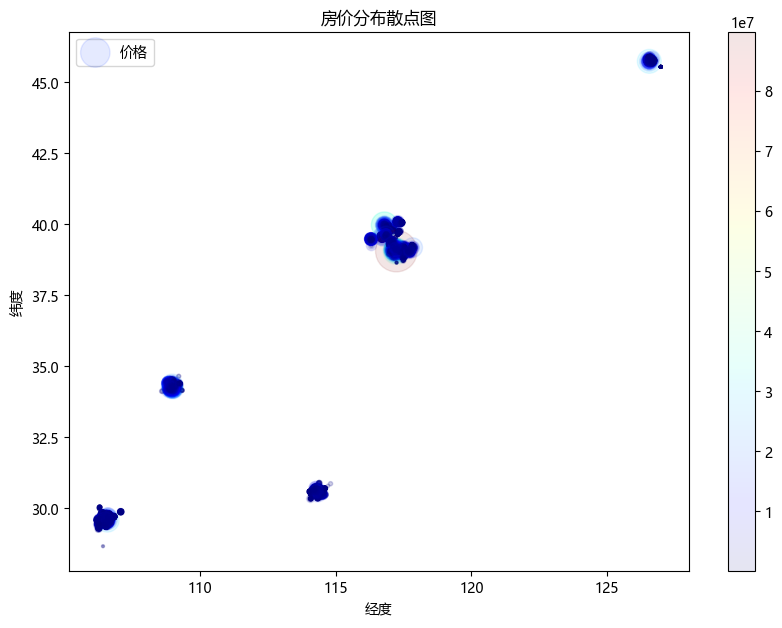

In [ ]:
# 画出scatter图，颜色表示价格，大小表示价格除以100000
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_cleaned['lon'], df_cleaned['lat'],
                     s=df_cleaned["价格"]/100000,  # 假设价格除以100来确定点的大小
                     c=df_cleaned["价格"],  # 假设 'median_house_value' 是颜色的依据
                     cmap=plt.get_cmap("jet"),
                     alpha=0.1,  # 点的透明度
                     label='价格')
plt.colorbar()  # 显示颜色条
plt.xlabel('经度')
plt.ylabel('纬度')
plt.title('房价分布散点图')
plt.legend(['价格'])  # 图例中文标注
plt.show()

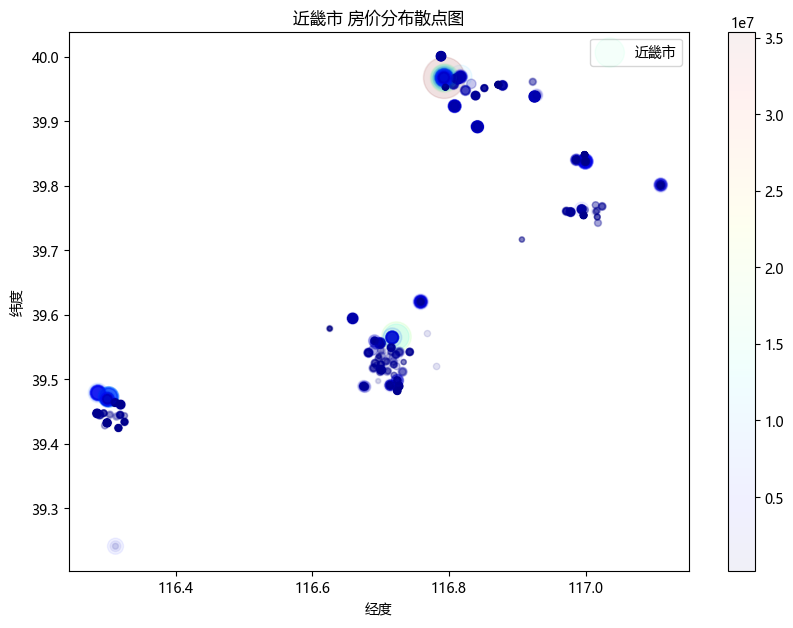

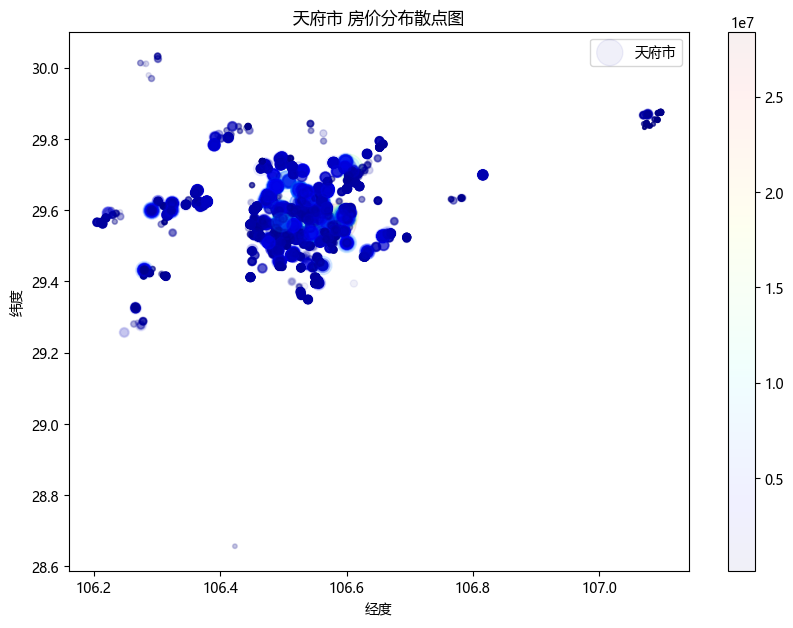

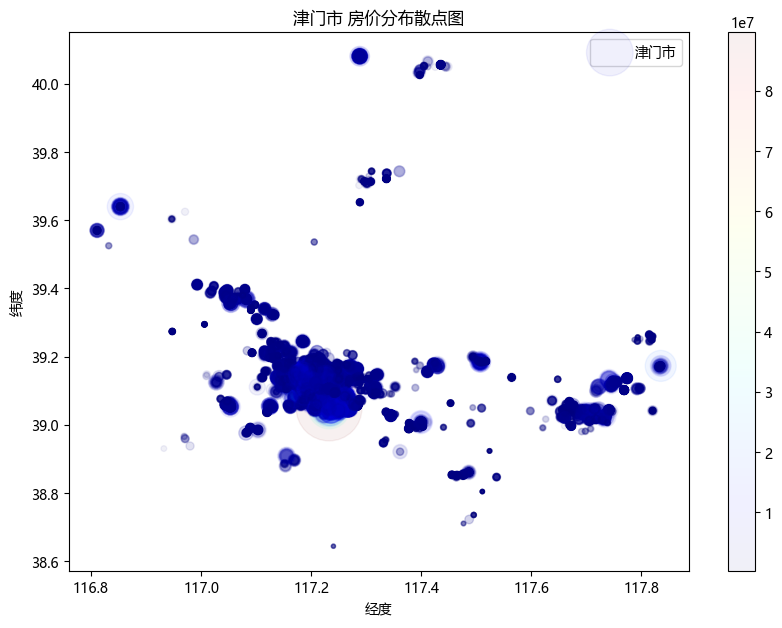

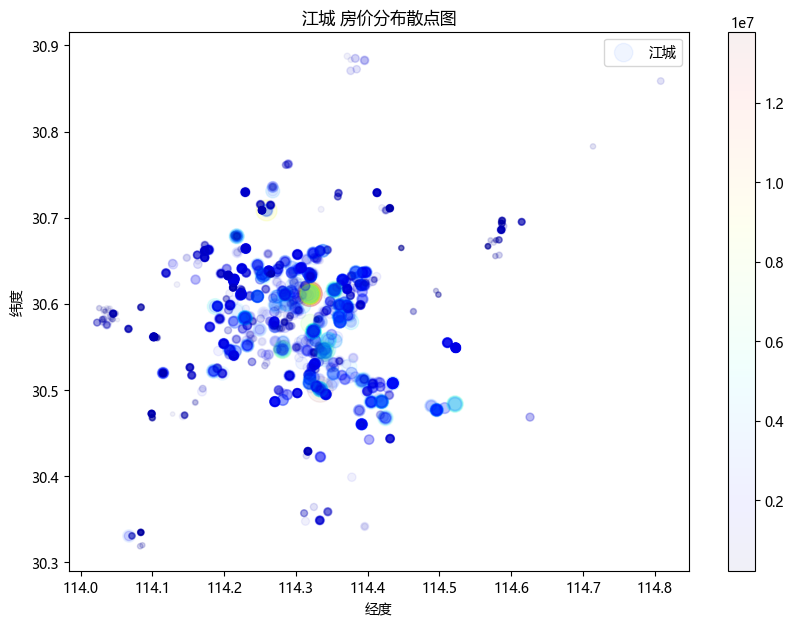

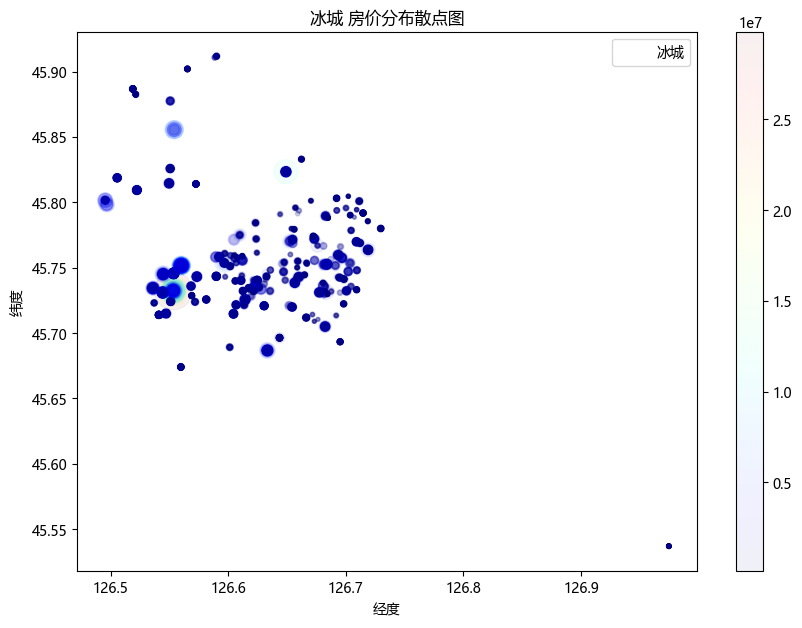

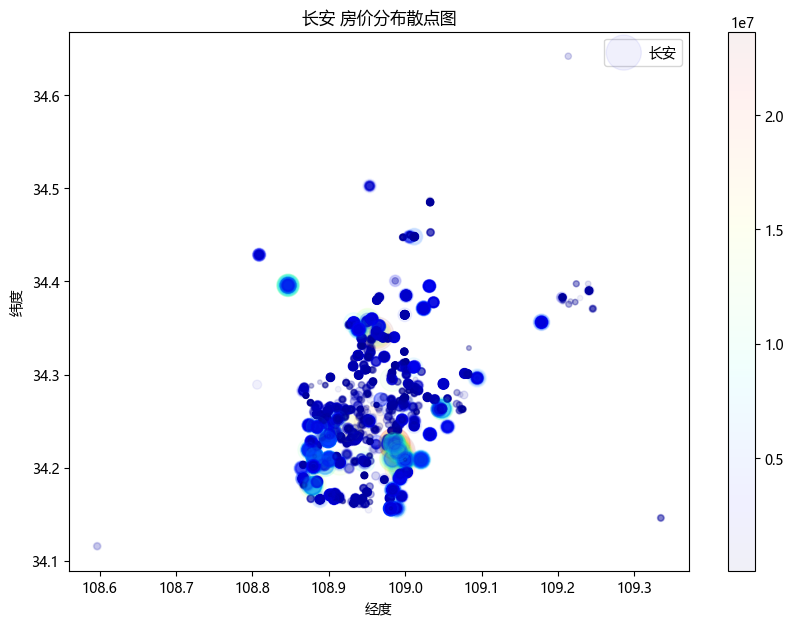

In [ ]:
import matplotlib.pyplot as plt

# 获取所有唯一的城市名
cities = df_cleaned['城市'].unique()

# 为每个城市创建一个散点图
for city in cities:
    # 筛选当前城市的数据
    city_data = df_cleaned[df_cleaned['城市'] == city]
    
    # 创建散点图
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(city_data['lon'], city_data['lat'],
                       s=city_data["价格"]/40000,  # 假设价格除以10000来确定点的大小
                       c=city_data["价格"],  # 使用 'price' 列的值作为颜色的依据
                       cmap=plt.get_cmap("jet"),
                       alpha=0.06,  # 点的透明度
                       label=city)  # 标注城市名
    plt.colorbar()  # 显示颜色条
    plt.xlabel('经度')
    plt.ylabel('纬度')
    plt.title(f'{city} 房价分布散点图')  # 使用城市名作为图表标题
    plt.legend()  # 显示图例
    plt.show()  # 显示图表

#### 1.3.2 关于经纬度处理的结论
由此处我们可以发现，经纬度对于房价的影响并不显著，因此我们不再使用经纬度数据进行回归建模.

主要是经纬度不够精确,差异相对太小

## Section 2: 构建线性回归模型


### 2.0 先构建数据集

In [ ]:
# df_cleaned = pd.read_csv('cleaned_data.csv')
df_cleaned.dropna(inplace=True)  # 删除空值
df_cleaned.reset_index(drop=True, inplace=True)  # 重置索引

# 导入数据集
X0 = df_cleaned.copy()
# print(X0.columns)
"""Output:
Index(['城市', '区域', '板块', '小区名称', '价格', '室数', '厅数', '厨数', '卫数', '总层数', '所在楼层',
       '建筑面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '交易时间', '交易权属', '房屋用途',
       '房屋年限', '产权所属', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '房屋总数',
       '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费', '停车位'],
      dtype='object')
"""

n_cleaned = X0.shape[0]
print(f"清洗后数据集中有 {n_cleaned} 条有效数据")
print(f"数据留存率有 {n_cleaned/n_ori:.2%}")

X = X0[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位','建筑结构']]

y = df_cleaned['价格']

# print(y.shape[0])

清洗后数据集中有 105071 条有效数据
数据留存率有 96.12%


### 2.1 画出clean出来的各种图像,来观察分布

#### 2.1.1 散点图

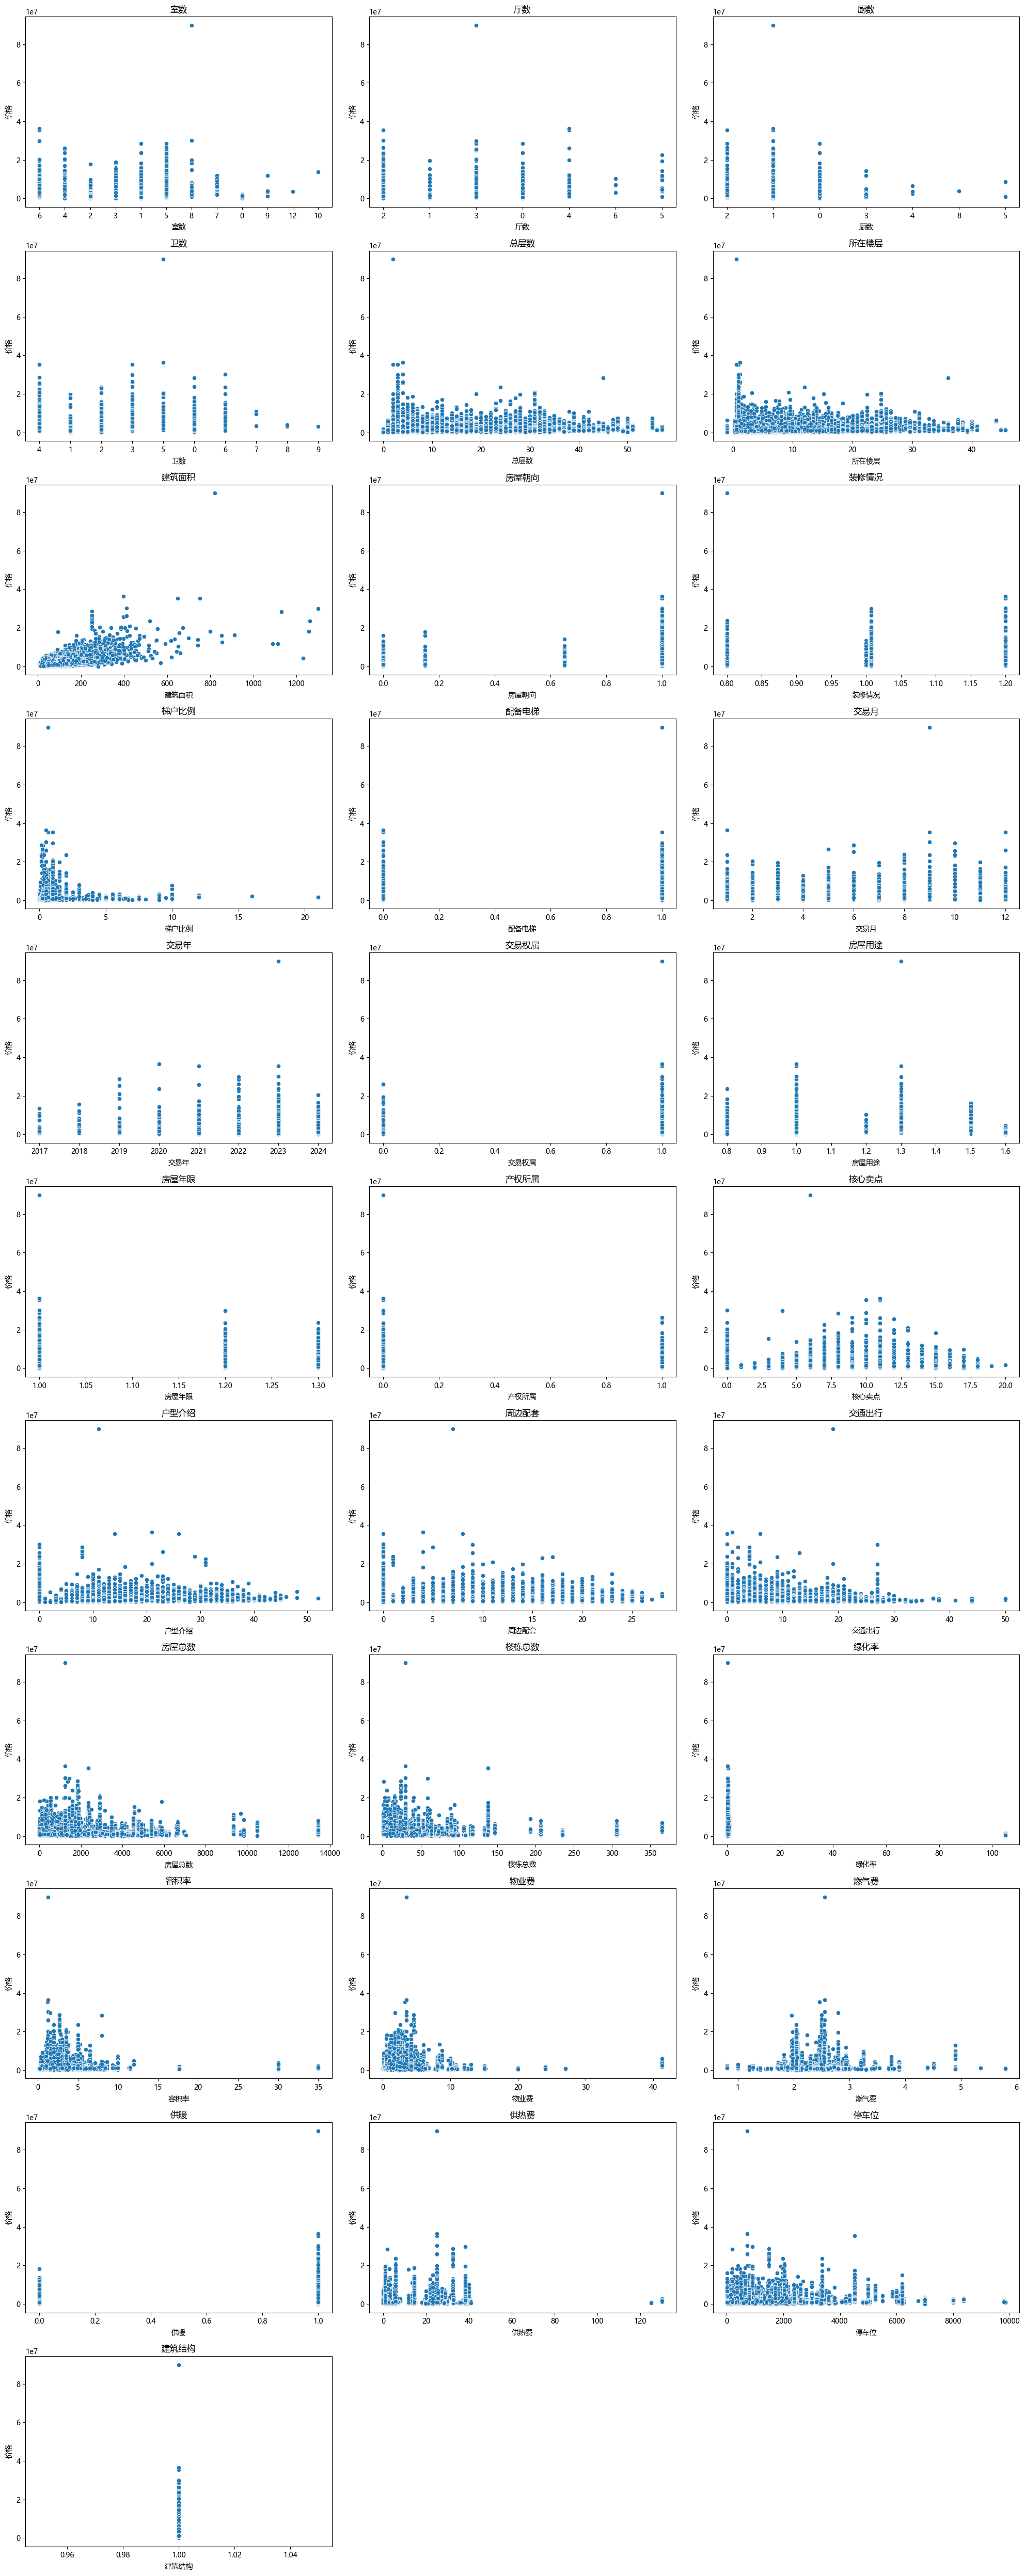

In [ ]:
# 设置图表大小
plt.figure(figsize=(20, 50))

# 计算需要的行数和列数
num_features = len(X.columns)
# print(num_features)
num_cols = 3  # 每行5个图
num_rows = (num_features + num_cols - 1) // num_cols  # 向上取整

# 遍历X中的每个特征
for i, feature in enumerate(X.columns):
    plt.subplot(num_rows, num_cols, i+1)  # 计算子图布局
    sns.scatterplot(x=feature, y=y, data=X0)  # 绘制散点图
    plt.title(feature)  # 设置子图标题为特征名称

plt.tight_layout()  # 调整子图间距
plt.show()

#### 2.1.2 X集的协方差矩阵

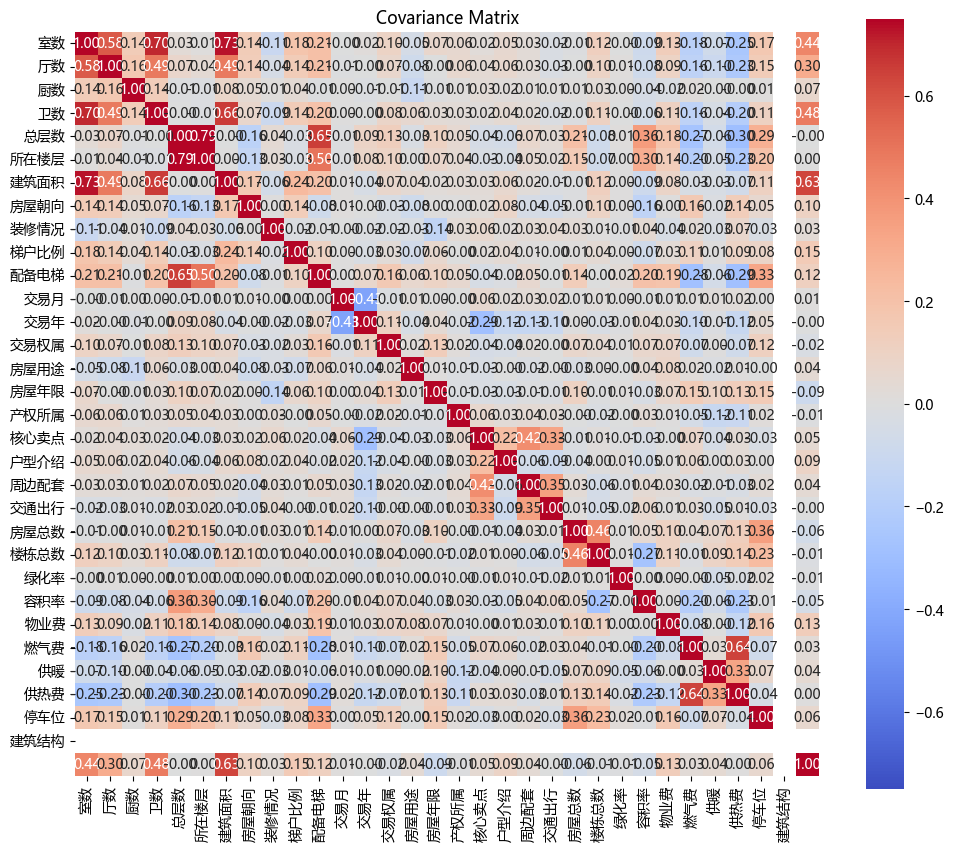

In [ ]:
corr_matrix = pd.concat([pd.DataFrame(X, columns=X.columns), y], axis=1).corr()

# 可视化相关系数矩阵
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, xticklabels=X.columns, yticklabels=X.columns, vmin=-0.75, vmax=0.75)
plt.title("Covariance Matrix")
plt.show()

In [ ]:
# 打印相关系数矩阵
print(corr_matrix)

            室数        厅数        厨数        卫数       总层数      所在楼层      建筑面积  \
室数    1.000000  0.576302  0.142985  0.701068  0.030423  0.009643  0.729484   
厅数    0.576302  1.000000  0.164920  0.485890  0.070933  0.039214  0.485164   
厨数    0.142985  0.164920  1.000000  0.135435 -0.008404 -0.012024  0.080650   
卫数    0.701068  0.485890  0.135435  1.000000 -0.000796 -0.012908  0.661916   
总层数   0.030423  0.070933 -0.008404 -0.000796  1.000000  0.785839 -0.004728   
所在楼层  0.009643  0.039214 -0.012024 -0.012908  0.785839  1.000000  0.003732   
建筑面积  0.729484  0.485164  0.080650  0.661916 -0.004728  0.003732  1.000000   
房屋朝向  0.143451  0.137006  0.045525  0.070073 -0.164752 -0.132299  0.167643   
装修情况 -0.108318 -0.044119  0.006052 -0.094625  0.040556  0.033694 -0.061323   
梯户比例  0.183612  0.143977  0.036268  0.144206 -0.025612 -0.028332  0.239046   
配备电梯  0.209692  0.210024 -0.009589  0.198658  0.652121  0.499254  0.199793   
交易月  -0.001501 -0.009108  0.000296  0.002597 -0.006977 -0.006513

我们发现建筑结构异常, 其主要原因是, 大多数的房屋都赋予了1, 导致标准化之后都近乎于1

#### 2.1.3 利用主成分分析法来观察一下变量之间的关系

In [ ]:
# 去除建筑结构
X = X.drop(['建筑结构'], axis=1, inplace=False)
# print(X.columns)

In [ ]:
# 排除最后一列“建筑结构”和“价格”
features = corr_matrix.iloc[:, :-2]

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# # 检查缺失值情况
# print("缺失值情况：\n", features.isnull().sum())
# 使用 SimpleImputer 填充 NaN 值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)
# print(X_imputed)

# 应用 PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_imputed)

X_new = pd.DataFrame(data=X_pca)  # 转换为数据框，方便后续使用
X_new.columns = [f'PC{i+1}' for i in range(X_new.shape[1])]  # 命名主成分列

# 查看主成分解释的方差比例
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.19697179 0.15341081 0.10493999 0.0676482  0.04927645 0.04856057
 0.04137225 0.03641357 0.03515513 0.03251832 0.03164133 0.02731752
 0.02487905 0.02356033 0.02112526 0.01987285 0.0156174  0.01282344
 0.01175522]


Explained variance ratio: [0.19697179 0.15341081 0.10493999 0.0676482  0.04927645 0.04856057
 0.04137225 0.03641357 0.03515513 0.03251832 0.03164133 0.02731752
 0.02487905 0.02356033 0.02112526 0.01987285 0.0156174  0.01282344
 0.01175522]


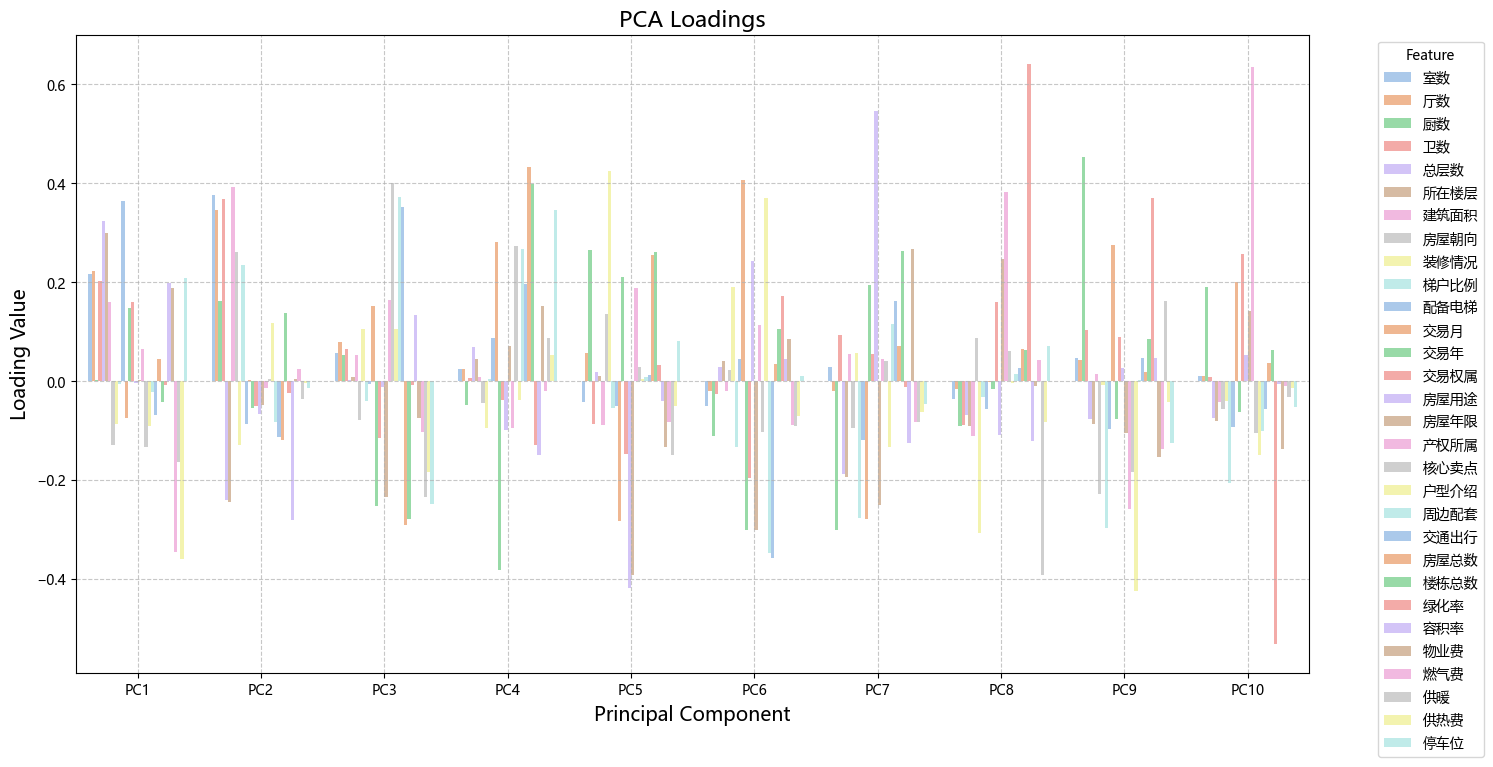

           PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
室数    0.216727  0.376374  0.056380  0.023066 -0.043246 -0.050333  0.028629   
厅数    0.221077  0.344457  0.078958  0.024115  0.056635 -0.019751 -0.020232   
厨数    0.002182  0.160676  0.052756 -0.049200  0.264066 -0.110656 -0.300760   
卫数    0.202678  0.367751  0.064666  0.006357 -0.088345 -0.026817  0.093479   
总层数   0.322194 -0.240273  0.001020  0.069041  0.017382  0.027650 -0.188045   
所在楼层  0.299016 -0.244705  0.007690  0.044873  0.008797  0.038991 -0.193959   
建筑面积  0.158383  0.391301  0.052792  0.007149 -0.088805 -0.020858  0.053829   
房屋朝向 -0.130731  0.259936 -0.078303 -0.045005  0.134915  0.020806 -0.095528   
装修情况 -0.086973 -0.130657  0.104634 -0.095551  0.424545  0.189876  0.055501   
梯户比例 -0.006751  0.233059 -0.041120  0.004457 -0.054617 -0.134338 -0.277012   
配备电梯  0.364295 -0.087472 -0.006971  0.086317 -0.051407  0.043301 -0.119407   
交易月  -0.075935  0.002337  0.151822  0.280153 -0.283203  0.405761

In [ ]:
# 我们来查看PCA的构成

# 查看主成分解释的方差比例
print("Explained variance ratio:", pca.explained_variance_ratio_)

# 查看主成分载荷
loadings = pd.DataFrame(pca.components_, columns=features.columns, index=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
# print(loadings)

loadings = loadings.iloc[:10]

# 设置图形大小
plt.figure(figsize=(15, 8))

# 将loadings转置，并创建一个数据框，以便于绘图
loadings_melted = loadings.reset_index().melt(id_vars='index', var_name='Feature', value_name='Loading Value')
loadings_melted.columns = ['Principal Component', 'Feature', 'Loading Value']

# 绘制柱状图
ax = sns.barplot(data=loadings_melted, x='Principal Component', y='Loading Value', hue='Feature', palette='pastel')

# 设置标题和标签
plt.title('PCA Loadings', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Loading Value', fontsize=14)

# 设置图例，放置在右侧
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

# 增加网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

print(loadings.T)


#### 2.1.4 设置一些新的X解释变量

In [ ]:
def reset_X(X):
    # 计算房屋总数
    X['房屋数'] = X['室数'] + X['厅数'] + X['卫数'] + X['厨数']
    X['房屋数'] = pd.to_numeric(X['房屋数'], errors='coerce')
    
    # 计算每屋面积，避免除以零
    X['每屋面积'] = X['建筑面积'] / X['房屋数'].where(X['房屋数'] != 0)
    
    # 删除原始的室数、厅数、卫数、厨数列
    X.drop(['室数', '厅数', '卫数', '厨数'], axis=1, inplace=True)
    
    # 创建与电梯相关的新特征
    X['总层数&配备电梯'] = X['总层数'] * X['配备电梯']
    X['所在楼层&配备电梯'] = X['所在楼层'] * X['配备电梯']
    # 计算所在楼层与总层数的比例，避免除以零
    X['所在楼层/总层数'] = X['所在楼层'] / X['总层数'].where(X['总层数'] != 0)
    
    # 删除不再需要的列
    X.drop(['总层数', '配备电梯', '所在楼层'], axis=1, inplace=True)
    
    # 计算房屋总数与楼栋总数的比例，避免除以零
    X['房屋总数/楼栋总数'] = X['房屋数'] / X['楼栋总数'].where(X['楼栋总数'] != 0)
    # 删除房屋总数列
    X.drop(['房屋总数'], axis=1, inplace=True)

    X['停车位'] = pd.to_numeric(X['停车位'], errors='coerce')
    
    # 计算停车位与房屋总数的比例，避免除以零
    X['停车位/房屋总数'] = X['停车位'] / X['房屋数'].where(X['房屋数'] != 0)
    
    return X

### 2.2 确定最终解释变量和被解释变量, 并分出训练集测试集

In [ ]:
X1 = df_cleaned.copy()

X = X1[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位']]

# print(X)

# 分别将每一列转换为数值类型，非数值转为NaN
X['室数'] = pd.to_numeric(X['室数'], errors='coerce')
X['厅数'] = pd.to_numeric(X['厅数'], errors='coerce')
X['卫数'] = pd.to_numeric(X['卫数'], errors='coerce')
X['厨数'] = pd.to_numeric(X['厨数'], errors='coerce')

print("缺失值情况：\n", X.isnull().sum())

# 创建一个简单的填充管道，使用列的均值来填充缺失值，这里进行简单的均值补充
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X = imputer.fit_transform(X)

X = pd.DataFrame(X, columns=['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位'])


X = reset_X(X)

# 创建一个简单的填充管道，使用列的均值来填充缺失值，这里进行简单的均值补充
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_temp = imputer.fit_transform(X)

X = pd.DataFrame(X_temp, columns=X.columns)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)


C:\Users\86183\AppData\Local\Temp\ipykernel_18040\3370717763.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['室数'] = pd.to_numeric(X['室数'], errors='coerce')
C:\Users\86183\AppData\Local\Temp\ipykernel_18040\3370717763.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['厅数'] = pd.to_numeric(X['厅数'], errors='coerce')
C:\Users\86183\AppData\Local\Temp\ipykernel_18040\3370717763.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

缺失值情况：
 室数      0
厅数      0
厨数      0
卫数      0
总层数     0
所在楼层    0
建筑面积    0
房屋朝向    0
装修情况    0
梯户比例    0
配备电梯    0
交易月     0
交易年     0
交易权属    0
房屋用途    0
房屋年限    0
产权所属    0
核心卖点    0
户型介绍    0
周边配套    0
交通出行    0
房屋总数    0
楼栋总数    0
绿化率     0
容积率     0
物业费     0
燃气费     0
供暖      0
供热费     0
停车位     0
dtype: int64


### 2.3 训练线性模型

In [ ]:
# 定义模型列表和超参数网格
models = {
    'OLS': LinearRegression(),
    'LASSO': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}
param_grid = {
    'LASSO': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]}
}

# 存储结果的字典
results = {}
grid_search_dict = {}  # 存储每个模型的GridSearchCV对象

# 训练模型并评估性能
for name, model in models.items():
    print(f"Processing model: {name}")
    
    if name in param_grid:
        # 使用网格搜索来寻找最佳参数
        grid_search = GridSearchCV(model, param_grid[name], cv=6, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        grid_search_dict[name] = grid_search  # 存储GridSearchCV对象
        
        # 获取最佳模型和参数
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_  # 取负号是因为scoring是负MAE
        
        # 样本内性能
        y_train_pred = best_model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        
        # 样本外性能
        y_test_pred = best_model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # 交叉验证性能
        cv_results = cross_validate(best_model, X_train, y_train, cv=6, scoring='neg_mean_absolute_error')
        cv_mae = -np.mean(cv_results['test_score'])
    else:
        # 对于没有超参数的模型，直接训练并评估
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        y_test_pred = model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        cv_results = cross_validate(model, X_train, y_train, cv=6, scoring='neg_mean_absolute_error')
        cv_mae = -np.mean(cv_results['test_score'])
        best_model = model
        best_params = "None"
        best_score = -np.mean(cv_results['test_score'])  # 取负号是因为scoring是负MAE

    # 存储结果
    results[name] = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'In sample MAE': train_mae,
        'Cross-validation MAE': cv_mae,
        'Testing MAE': test_mae
    }
    
    # 打印模型的预测结果
    print(f"Model: {name}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Score (Negative MAE): {best_score:.2f}")
    print(f"In sample predictions (MAE): {train_mae:.2f}")
    print(f"Cross-validation predictions (MAE): {cv_mae:.2f}")
    print(f"Testing predictions (MAE): {test_mae:.2f}")
    print(f"Sample in sample predictions: {y_train_pred[:5]}")
    print(f"Sample test predictions: {y_test_pred[:5]}")

    # 获取系数
    coefficients = best_model.coef_
    # 打印系数
    print("Coefficients:", coefficients)
    # 如果您还想要查看截距
    intercept = best_model.intercept_
    print("Intercept:", intercept)

    print('-----------------------------------')

# 打印所有模型的结果
print("Summary of results:")
for name, res in results.items():
    print(f"{name} | Best Parameters: {res['Best Parameters']}, Best Score: {res['Best Score']:.2f}, In sample: {res['In sample MAE']:.2f}, Cross-validation: {res['Cross-validation MAE']:.2f}, Testing: {res['Testing MAE']:.2f}")

Processing model: OLS
Model: OLS
Best Parameters: None
Best Score (Negative MAE): 580062.75
In sample predictions (MAE): 579703.42
Cross-validation predictions (MAE): 580062.75
Testing predictions (MAE): 582278.13
Sample in sample predictions: [1817111.57621196 1297521.32601812 1254625.05627266 1156713.59972242
  995672.1032629 ]
Sample test predictions: [ 811288.52843589 1591596.1723721  1459432.95618549 2087008.59447977
  484075.67876473]
Coefficients: [ 1.89982559e+04 -5.38321875e+04  5.85399009e+05 -4.51372656e+04
  8.60143794e+03  7.81591398e+04 -3.05453200e+05  2.32442232e+05
 -1.32113328e+06 -7.71415450e+04  7.26660878e+03  7.60082178e+03
  3.16874532e+03 -1.66228740e+03 -4.80952829e+03 -2.52178870e+03
 -3.89732257e+02  6.49118325e+04  1.90553280e+05  2.74578193e+05
  4.53859554e+03  5.26167717e+01  3.04535794e+04 -3.18090400e+03
 -8.36655159e+03  1.93123948e+04 -5.35593095e+05 -4.83038058e+04
 -2.59809063e+02]
Intercept: -158075875.06492954
-----------------------------------
P

## Section 3: 预测test数据集信息

### 3.1 处理test数据集 clean

In [ ]:
df_pre_cleaned = pd.DataFrame()
print(merged_df_pre.columns)
print()
df_pre_cleaned = clean_data(df_pre_cleaned, merged_df_pre)
df_pre_cleaned.to_csv('cleaned_data_pre.csv', index=False, encoding='utf-8-sig')

NameError: name 'merged_df_pre' is not defined

In [3]:
df_pre_cleaned = pd.read_csv('cleaned_data_pre.csv')
print(df_pre_cleaned.isnull().sum())

城市         0
区域         0
板块         0
小区名称       0
室数         0
厅数         0
厨数         0
卫数         0
总层数        0
所在楼层       0
建筑面积       0
房屋朝向       0
建筑结构       0
装修情况       0
梯户比例      34
配备电梯     540
交易时间     540
交易月      540
交易年      540
交易权属     540
房屋用途     540
房屋年限    1160
产权所属    1160
核心卖点    1160
户型介绍    1160
周边配套    1160
交通出行    1160
lon     1160
lat     1160
房屋总数    2313
楼栋总数    2313
绿化率     2313
容积率     2313
物业费     2313
燃气费     2313
供暖      2313
供热费     2313
停车位     2313
dtype: int64


### 3.2 使用模型进行预测

In [ ]:

# 导入数据集
X0_pre = df_pre_cleaned.copy()

# 选择特定的列
X_pre = X0_pre[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位']]

# 将每一列转换为数值类型，非数值转为NaN
X_pre[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位']] = X_pre[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',
       '配备电梯', '交易月', '交易年', '交易权属', '房屋用途', '房屋年限', '产权所属', '核心卖点', '户型介绍',
       '周边配套', '交通出行', '房屋总数', '楼栋总数', '绿化率', '容积率', '物业费', '燃气费', '供暖', '供热费',
       '停车位']].apply(pd.to_numeric, errors='coerce')

# 打印缺失值情况
# print("缺失值情况：\n", X_pre.isnull().sum())

# 使用中位数填充NaN值
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_pre_temp = imp_median.fit_transform(X_pre)

# 将Numpy数组转换回DataFrame
X_pre = pd.DataFrame(X_pre_temp, columns=X_pre.columns)

# 第二次填充：检查是否有剩余的NaN值，并用0填充
imp_constant = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_pre_temp = imp_constant.fit_transform(X_pre)

# 将Numpy数组转换回DataFrame
X_pre = pd.DataFrame(X_pre_temp, columns=X_pre.columns)

# 应用reset_X函数（假设此函数已定义）
X_pre = reset_X(X_pre)

for col in X_pre.columns:
       X_pre = mode_complete(X_pre, col_name_complete=col, col_name_basis='建筑面积', others=0)



C:\Users\86183\AppData\Local\Temp\ipykernel_18040\1473405913.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pre[['室数', '厅数', '厨数', '卫数', '总层数', '所在楼层', '建筑面积', '房屋朝向', '装修情况', '梯户比例',


KeyboardInterrupt: 

In [ ]:
# 模型预测
predictions = {}
for name in results.keys():
    # 检查模型是否进行了网格搜索
    if name in grid_search_dict:
        # 获取最佳模型
        best_model = grid_search_dict[name].best_estimator_
    else:
        # 对于没有进行网格搜索的模型，使用原始模型
        best_model = models[name]
    
    # 使用最佳模型或原始模型进行预测
    y_pred = best_model.predict(X_pre)
    predictions[name] = y_pred
    
    # 将预测结果保存到DataFrame
    y_pre = pd.DataFrame(y_pred, columns=['Price'])
    y_pre.reset_index(inplace=True)
    y_pre.rename(columns={'index': 'ID'}, inplace=True)
    
    # 将数据框保存为CSV文件，不保存默认索引
    y_pre.to_csv(f'{name}.csv', index=False)

# 将预测结果放入一个新的DataFrame中，以便于查看
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

                OLS         LASSO         Ridge    ElasticNet
0      9.669718e+05  9.690772e+05  9.779236e+05  1.027641e+06
1      1.325607e+06  1.327023e+06  1.320633e+06  1.304982e+06
2      1.792857e+06  1.792840e+06  1.780141e+06  1.728307e+06
3      1.624556e+06  1.624048e+06  1.608799e+06  1.547621e+06
4      1.829420e+06  1.826159e+06  1.807656e+06  1.711977e+06
...             ...           ...           ...           ...
19293  8.589247e+05  8.606204e+05  8.793802e+05  9.521781e+05
19294  2.119349e+06  2.116797e+06  2.099788e+06  2.017950e+06
19295  2.226935e+06  2.228486e+06  2.234095e+06  2.263804e+06
19296  1.970010e+06  1.971257e+06  1.963813e+06  1.939304e+06
19297  2.492836e+06  2.493077e+06  2.480766e+06  2.431880e+06

[19298 rows x 4 columns]


## Section 4: 增加变量

### 4.1 poly二次项

In [ ]:
# 创建PolynomialFeatures实例，degree=2表示生成二次项
poly = PolynomialFeatures(degree=2)

# 对训练数据X进行变换
X_poly = poly.fit_transform(X)

# 划分数据集
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=111)


### 4.2 训练模型

In [ ]:
# 定义模型列表
models = {
    'OLS': LinearRegression(),
    'LASSO': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# 存储结果的字典
results = {}

# 训练模型并评估性能
for name, model in models.items():
    print(f"Processing model: {name}")
    
    # 训练模型
    model.fit(X_train_poly, y_train)
    
    # 样本内性能
    y_train_pred = model.predict(X_train_poly)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # 样本外性能
    y_test_pred = model.predict(X_test_poly)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # 交叉验证性能
    cv_results = cross_validate(model, X_train_poly, y_train, cv=6, scoring='neg_mean_absolute_error')
    cv_mae = -np.mean(cv_results['test_score'])
    
    # 存储结果
    results[name] = {
        'In sample MAE': train_mae,
        'Cross-validation MAE': cv_mae,
        'Testing MAE': test_mae
    }
    
    # 打印模型的预测结果
    print(f"Model: {name}")
    print(f"In sample predictions (MAE): {train_mae:.2f}")
    print(f"Cross-validation predictions (MAE): {cv_mae:.2f}")
    print(f"Testing predictions (MAE): {test_mae:.2f}")
    print(f"Sample in sample predictions: {y_train_pred[:5]}")
    print(f"Sample test predictions: {y_test_pred[:5]}")

    # 获取系数
    coefficients = model.coef_
    # 打印系数
    print("Coefficients:", coefficients)
    # 如果您还想要查看截距
    intercept = model.intercept_
    print("Intercept:", intercept)

    print('-----------------------------------')

# 打印所有模型的结果
print("Summary of results:")
for name, res in results.items():
    print(f"{name} | In sample: {res['In sample MAE']:.2f}, Cross-validation: {res['Cross-validation MAE']:.2f}, Testing: {res['Testing MAE']:.2f}")

Processing model: OLS
Model: OLS
In sample predictions (MAE): 490817.57
Cross-validation predictions (MAE): 498111.14
Testing predictions (MAE): 499363.50
Sample in sample predictions: [1415640.96531677  976787.46795654 1264171.0597229   333412.69515991
  538733.72868347]
Sample test predictions: [1469432.3581543   778877.89421082  998834.3407135  2008786.60273743
  490013.96089172]
Coefficients: [-6.69754481e-01 -1.58661495e+06 -1.08803588e+07 -9.08849459e+06
  1.82477045e+07 -1.76744690e+07 -1.11599434e+08 -5.18328139e+07
  2.86846250e+07  1.52722386e+07 -1.43567235e+07 -1.45675972e+06
 -1.71560276e+06 -2.59023637e+06  2.60739622e+06  6.63756365e+05
  4.60909264e+06  1.66693149e+07 -6.62286193e+06 -1.16920888e+08
 -5.67164007e+06 -1.06075414e+06 -1.45444575e+05  2.81560845e+07
  1.47487961e+07  1.57652712e+06  2.69827586e+06 -7.79674506e+07
 -1.61562965e+07  4.16120134e+04  4.74602608e-01  5.91003416e+03
 -7.43719724e+03  4.80055964e+03  9.41444616e+02  1.56447871e+03
 -8.84861118e+0

c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.817e+16, tolerance: 1.445e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.375e+16, tolerance: 1.227e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e+16, toleranc

Model: LASSO
In sample predictions (MAE): 494152.92
Cross-validation predictions (MAE): 500376.56
Testing predictions (MAE): 501225.30
Sample in sample predictions: [1417290.01337102 1055637.99685985 1122819.85114893  291356.42125204
  487536.88267352]
Sample test predictions: [1449865.08472247  814956.02381375 1021810.91998038 1957379.94420518
  488568.19993642]
Coefficients: [ 0.00000000e+00  2.69074840e+04  1.47501329e+06 -1.17693779e+06
  8.34083828e+05  9.64494141e+04  1.36746523e+04 -9.34542852e+05
  2.57638502e+04  5.63883677e+06  3.13556019e+05  3.94850841e+04
  1.03282931e+05 -1.30369076e+04  1.70557582e+04 -1.55203243e+04
 -3.11917536e+04 -5.90768373e+05  1.36140490e+05  2.20550383e+06
 -1.26707675e+06 -1.05937378e+04  1.20351999e+02  1.54111593e+05
 -5.15164958e+03  1.89694420e+04  1.42993021e+04  3.35804570e+05
 -1.98254108e+05 -3.77752832e+02 -1.06035359e+01  5.52033843e+03
 -5.00461787e+03  5.13671032e+03  7.92027286e+02 -7.70028826e+00
 -9.22790485e+03  1.12999429e+04 -2

c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.02256e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.22787e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.2091e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24609e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216

Model: Ridge
In sample predictions (MAE): 491021.53
Cross-validation predictions (MAE): 497922.64
Testing predictions (MAE): 499039.22
Sample in sample predictions: [1447998.86722142 1023735.85103887 1221482.73487884  354237.11233836
  513375.65682238]
Sample test predictions: [1453144.97412342  781701.41968596  997835.38832819 2037991.9509272
  482811.93296748]
Coefficients: [ 0.00000000e+00 -1.89900261e+05 -4.73091047e+04  7.52090831e+00
  2.36643176e+04 -7.01549168e+05 -4.87343276e+05 -1.51251787e+05
  1.10715192e+03 -3.00658590e+04 -2.34913802e+04 -1.06891168e+05
 -2.50584839e+05 -6.96221093e+05  5.30654907e+05  5.45026387e+05
  2.72965244e+05  4.10747418e+05 -1.13922581e+05 -1.41824361e+05
 -1.17391264e+04 -2.01508213e+06  3.42560759e+03  2.28824812e+05
  1.59335407e+06  1.90125719e+06  6.17896141e+05 -3.26207459e+04
 -1.23263181e+05  5.92791277e+04  1.12521606e+00  5.90492743e+03
 -6.01196767e+03  4.88558154e+03  8.01710569e+02  2.00383350e+02
 -8.82550937e+03  1.10267297e+04 -3.

c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.920e+16, tolerance: 1.445e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e+16, tolerance: 1.227e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e+16, toleranc

Model: ElasticNet
In sample predictions (MAE): 498307.74
Cross-validation predictions (MAE): 502964.67
Testing predictions (MAE): 504779.54
Sample in sample predictions: [1378404.33022269 1042185.69560891 1098442.27939312  452332.67985844
  498541.23727822]
Sample test predictions: [1454365.20153794  794577.91882734 1064367.78385947 1873742.60906434
  439439.73938785]
Coefficients: [ 0.00000000e+00  1.51131667e+04 -4.11011756e+01 -6.65318961e+00
  2.51522008e+00  1.78792457e+01  8.87753598e+01  1.67884907e+01
 -1.14546664e+00  3.53199639e+00  4.50568881e+01 -1.21397132e+03
 -2.04200946e+03  1.27660075e+02  2.20343036e+02 -1.20768625e+04
 -2.37929178e+03  3.80594999e+02  2.15511524e+02 -1.23958984e+02
  5.71755664e+00  3.76662756e+04  1.47434790e+02 -8.66856112e+02
  8.53711680e+03 -7.11917933e+03 -2.84470629e+03  3.55157298e+01
 -5.93212411e+02 -4.47738445e+01 -5.54355541e+00  3.57252018e+03
  3.60835321e+03  2.73426953e+03  7.43621977e+02 -3.22902154e+00
 -5.03623434e+03  6.98976276e+

c:\Users\86183\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.431e+16, tolerance: 1.223e+13
  model = cd_fast.enet_coordinate_descent(


### 4.3 得出预测结果

In [ ]:
# 对预测数据X_pre进行变换
# 注意：我们需要使用相同的PolynomialFeatures实例来确保特征一致性
X_pre = poly.transform(X_pre)

# 模型预测
predictions = {}
for name in results.keys():
    # 检查模型是否进行了网格搜索
    if name in grid_search_dict:
        # 获取最佳模型
        best_model = grid_search_dict[name].best_estimator_
    else:
        # 对于没有进行网格搜索的模型，使用原始模型
        best_model = models[name]
    
    # 使用最佳模型或原始模型进行预测
    y_pred = best_model.predict(X_pre)
    predictions[name] = y_pred
    
    # 将预测结果保存到DataFrame
    y_pre = pd.DataFrame(y_pred, columns=['Price'])
    y_pre.reset_index(inplace=True)
    y_pre.rename(columns={'index': 'ID'}, inplace=True)
    
    # 将数据框保存为CSV文件，不保存默认索引
    y_pre.to_csv(f'{name}_poly.csv', index=False)

# 将预测结果放入一个新的DataFrame中，以便于查看
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

                OLS         LASSO         Ridge    ElasticNet
0      1.108284e+06  1.066797e+06  1.060997e+06  9.591139e+05
1      1.390915e+06  1.471359e+06  1.382422e+06  1.373148e+06
2      1.657610e+06  1.601949e+06  1.639944e+06  1.966016e+06
3      1.392253e+06  1.491386e+06  1.380083e+06  1.573586e+06
4      1.763621e+06  1.793642e+06  1.737159e+06  1.560795e+06
...             ...           ...           ...           ...
19293  1.311941e+06  1.209325e+06  1.232355e+06  9.908840e+05
19294  1.813219e+06  1.824046e+06  1.754430e+06  1.873945e+06
19295  2.474833e+06  2.360083e+06  2.342190e+06  2.323670e+06
19296  1.987596e+06  1.872538e+06  1.852574e+06  1.999047e+06
19297  2.537069e+06  2.430056e+06  2.411149e+06  2.572892e+06

[19298 rows x 4 columns]
